In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import shap

# TOY dataframe

In [2]:
df = pd.read_parquet("../data/interim/dfit_ensemble_2022-07-01_2025-10-01_V.1.0.parquet")

In [3]:
df.columns

Index(['reporting_month', 'ISRC', 'spotify', 'release_type', 'continent',
       'zone', 'quantity', 'unit_price', 'mechanical_fee', 'share_rate',
       'revenue'],
      dtype='object')

In [4]:
df.head()

,reporting_month,ISRC,spotify,release_type,continent,zone,quantity,unit_price,mechanical_fee,share_rate,revenue
0,2023/11/01,CA-5KR-21-33832,Spotify,Music Release,Asia,Cambodia,1,0.000001,0.0,0.765,7.650000e-07
1,2023/11/01,GX-5MX-22-11692,Other,Music Release,Africa,Uganda,2,0.000006,0.0,0.765,9.764572e-06
2,2023/11/01,GX-5MX-22-90812,Spotify,Music Release,Africa,Nigeria,1,0.000017,0.0,0.765,1.300500e-05
3,2023/11/01,GX-5MX-22-11692,Other,Music Release,Africa,Tunisia,2,0.000009,0.0,0.765,1.373399e-05
4,2023/11/01,GX-5MX-22-11692,Other,Music Release,LATAM,Nicaragua,1,0.000020,0.0,0.765,1.522488e-05


In [5]:
# Prepare the data
# Separate features and target
X = df.drop(['reporting_month', 'unit_price', 'mechanical_fee', 'share_rate', 'revenue'], axis=1)
y = df['revenue']

# Encode categorical variables
le_dict = {}
categorical_cols = ['ISRC', 'spotify', 'release_type', 'continent', 'zone']

X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    le_dict[col] = le

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [12]:
X_test.release_type.unique()

array([0])

In [6]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions and metrics
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=" * 60)
print("MODEL METRICS")
print("=" * 60)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2e}")
print(f"RMSE: {rmse:.2e}")
print()

MODEL METRICS
R² Score: 0.9681
MAE: 1.45e-01
RMSE: 6.54e-01



FEATURE IMPORTANCE (Random Forest)
     feature  importance
    quantity    0.912187
        zone    0.035780
     spotify    0.026414
   continent    0.013694
        ISRC    0.011926
release_type    0.000000



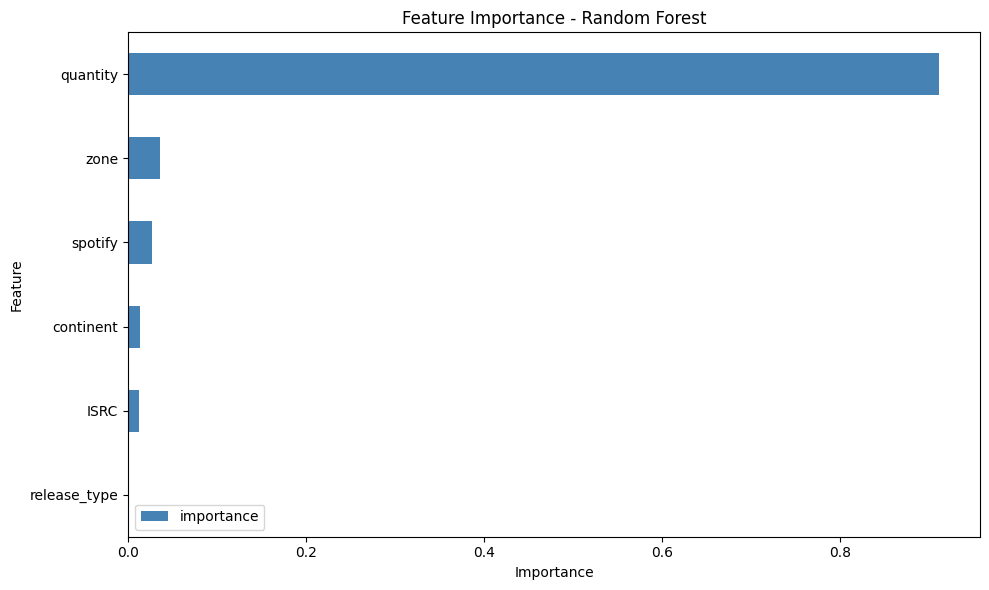

In [7]:
# Feature Importance from Random Forest
print("=" * 60)
print("FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))
print()

# Feature Importance visualization
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=ax, color='steelblue'
)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

SHAP ANALYSIS
Computing SHAP values (may take a moment)...


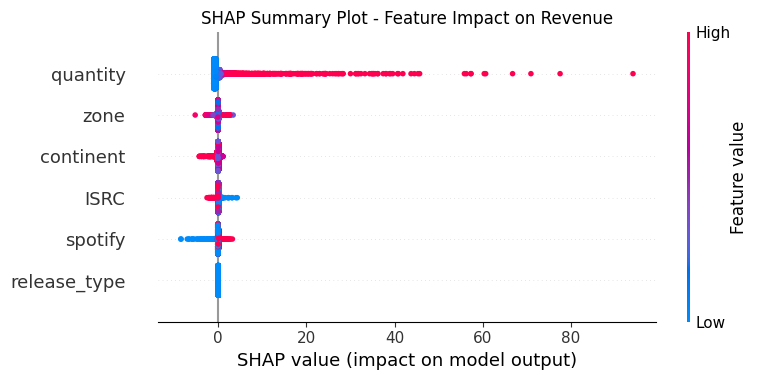

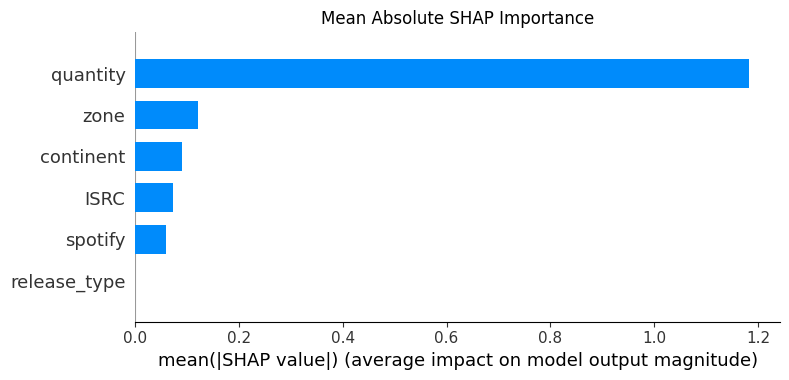


INTERPRETATION

DIFFERENCES BETWEEN FEATURE IMPORTANCE AND SHAP:

1. Feature Importance (RF):
   - Measures how much each variable improves the model globally
   - Based on impurity reduction (Gini/variance)
   - Can be biased towards variables with many categories

2. SHAP Values:
   - Shows the marginal impact of each variable
   - Considers interactions between variables
   - More robust and theoretically grounded
   - Allows seeing effect direction (positive/negative)

RECOMMENDATIONS:
- If quantity, unit_price and share_rate are most important:
  this makes sense because revenue = quantity × unit_price × share_rate
- If ISRC/zone are important: there may be specific patterns 
  per song or region that affect revenue
- SHAP is especially useful here to understand how each specific
  value of the variables affects individual revenue


EXAMPLE: SHAP EXPLANATION FOR ONE PREDICTION
Actual revenue: 2.30e-03
Predicted revenue: 1.13e-02

Contribution of each variable (SHAP values):
  ISR

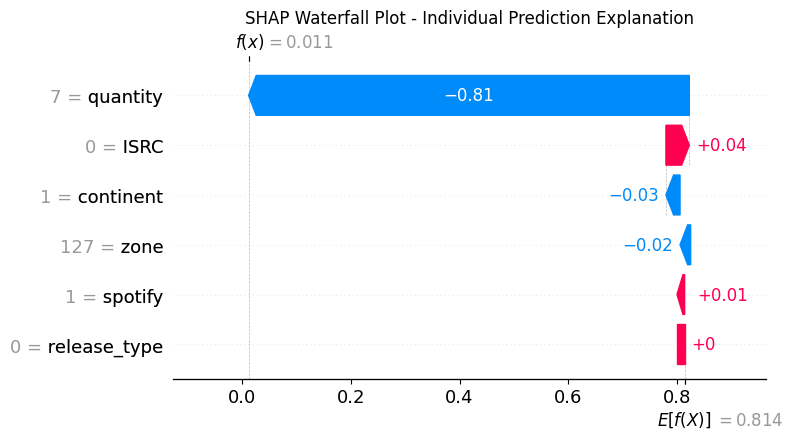

In [10]:
# SHAP Analysis
print("=" * 60)
print("SHAP ANALYSIS")
print("=" * 60)
print("Computing SHAP values (may take a moment)...")

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X_encoded.columns, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Revenue')
plt.tight_layout()
plt.show()

# Bar plot with mean absolute SHAP importance
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X_encoded.columns, 
                  plot_type="bar", show=False)
plt.title('Mean Absolute SHAP Importance')
plt.tight_layout()
plt.show()

print()
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("""
DIFFERENCES BETWEEN FEATURE IMPORTANCE AND SHAP:

1. Feature Importance (RF):
   - Measures how much each variable improves the model globally
   - Based on impurity reduction (Gini/variance)
   - Can be biased towards variables with many categories
   
2. SHAP Values:
   - Shows the marginal impact of each variable
   - Considers interactions between variables
   - More robust and theoretically grounded
   - Allows seeing effect direction (positive/negative)

RECOMMENDATIONS:
- If quantity, unit_price and share_rate are most important:
  this makes sense because revenue = quantity × unit_price × share_rate
- If ISRC/zone are important: there may be specific patterns 
  per song or region that affect revenue
- SHAP is especially useful here to understand how each specific
  value of the variables affects individual revenue
""")

# Example of individual prediction with SHAP
if len(X_test) > 0:
    print("\n" + "=" * 60)
    print("EXAMPLE: SHAP EXPLANATION FOR ONE PREDICTION")
    print("=" * 60)
    
    sample_idx = 0
    sample = X_test.iloc[sample_idx:sample_idx+1]
    
    shap_values_sample = explainer.shap_values(sample)
    
    print(f"Actual revenue: {y_test.iloc[sample_idx]:.2e}")
    print(f"Predicted revenue: {rf_model.predict(sample)[0]:.2e}")
    print("\nContribution of each variable (SHAP values):")
    
    for feat, shap_val in zip(X_encoded.columns, shap_values_sample[0]):
        print(f"  {feat}: {shap_val:.2e}")
    
    # Waterfall plot for individual prediction
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_sample[0],
            base_values=explainer.expected_value,
            data=sample.values[0],
            feature_names=X_encoded.columns.tolist()
        ),
        show=False
    )
    plt.title('SHAP Waterfall Plot - Individual Prediction Explanation')
    plt.tight_layout()
    plt.show()

# Full dataframe

In [13]:
df = pd.read_parquet("../data/interim/dfi_ensemble_2022-07-01_2025-10-01_V.1.0.parquet")

In [14]:
df.columns

Index(['reporting_month', 'ISRC', 'spotify', 'release_type', 'continent',
       'zone', 'quantity', 'unit_price', 'mechanical_fee', 'share_rate',
       'revenue'],
      dtype='object')

In [15]:
df.head()

,reporting_month,ISRC,spotify,release_type,continent,zone,quantity,unit_price,mechanical_fee,share_rate,revenue
0,2022/09/01,CA-5KR-00-21353,Other,Music Release,Europe,Italy,1,0.000007,0.0,0.765,0.000005
1,2022/09/01,GX-5MX-22-31727,Other,Music Release,Europe,Turkey,1,0.000007,0.0,0.765,0.000005
2,2022/09/01,GX-5MX-22-31730,Other,Music Release,LATAM,Uruguay,1,0.000010,0.0,0.765,0.000008
3,2022/09/01,CA-5KR-21-13899,Other,Music Release,Europe,Bosnia and herzegovi,5,0.000002,0.0,0.765,0.000008
4,2022/09/01,CA-5KR-21-77573,Other,Music Release,Asia,Jordan,1,0.000014,0.0,0.765,0.000011


In [16]:
# Prepare the data
# Separate features and target
X = df.drop(['reporting_month', 'unit_price', 'mechanical_fee', 'share_rate', 'revenue'], axis=1)
y = df['revenue']

# Encode categorical variables
le_dict = {}
categorical_cols = ['ISRC', 'spotify', 'release_type', 'continent', 'zone']

X_encoded = X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    le_dict[col] = le

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [17]:
X_test.release_type.unique()

array([0, 1])

In [18]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions and metrics
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=" * 60)
print("MODEL METRICS")
print("=" * 60)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2e}")
print(f"RMSE: {rmse:.2e}")
print(f"Total Revenue Real: {y_test.sum()}")
print(f"Total Revenue Pred: {y_pred.sum()}")
print(f"Total Absolute Error: {abs(y_test.sum() - y_pred.sum())}")
print()

MODEL METRICS
R² Score: 0.8930
MAE: 1.23e-01
RMSE: 1.25e+00



In [103]:
dummy_pred = (X_test['quantity'] * 2 / 1000).values
individual_errors_dummy = y_test - dummy_pred

r2_dummy = r2_score(y_test, dummy_pred)
mae_dummy = mean_absolute_error(y_test, dummy_pred)
rmse_dummy = np.sqrt(mean_squared_error(y_test, dummy_pred))
individual_std_dummy = np.std(individual_errors_dummy)

y_pred = rf_model.predict(X_test)
individual_errors_rf = y_test - y_pred

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
individual_std_rf = np.std(individual_errors_rf)

# Only Spotify

desired_index = X_test[X_test['spotify'] == 1].index
X_test_spoti = X_test.loc[desired_index]
y_test_spoti = y_test.loc[desired_index]

dummy_pred_spoti = (X_test_spoti['quantity'] * 2 / 1000).values
individual_errors_dummy_spoti = y_test_spoti - dummy_pred_spoti

r2_dummy_spoti = r2_score(y_test_spoti, dummy_pred_spoti)
mae_dummy_spoti = mean_absolute_error(y_test_spoti, dummy_pred_spoti)
rmse_dummy_spoti = np.sqrt(mean_squared_error(y_test_spoti, dummy_pred_spoti))
individual_std_dummy_spoti = np.std(individual_errors_dummy_spoti)

y_pred_spoti = rf_model.predict(X_test_spoti)
individual_errors_rf_spoti = y_test_spoti - y_pred_spoti

r2_spoti = r2_score(y_test_spoti, y_pred_spoti)
mae_spoti = mean_absolute_error(y_test_spoti, y_pred_spoti)
rmse_spoti = np.sqrt(mean_squared_error(y_test_spoti, y_pred_spoti))
individual_std_rf_spoti = np.std(individual_errors_rf_spoti)

In [107]:
std_dummy_spoti = individual_std_dummy_spoti * np.sqrt(len(individual_errors_dummy_spoti))
std_rf_spoti = individual_std_rf_spoti * np.sqrt(len(individual_errors_rf_spoti))

std_dummy = individual_std_dummy * np.sqrt(len(individual_errors_dummy))
std_rf = individual_std_rf * np.sqrt(len(individual_errors_rf))

print(f"Total Revenue Real: {y_test.sum():.2f}€")
print(f" -> Spotify generates: {y_test_spoti.sum():.2f}€")
print(f" -> Non-Spotify platforms generate: {y_test.sum() - y_test_spoti.sum():.2f}€")
print()
print("*******************")
print("      SPOTIFY      ")
print("*******************")
print("1) DUMMY:")
print(f"  -> Total Revenue Dumm: {dummy_pred_spoti.sum():.2f}€ ± {std_dummy_spoti:.2f}€")
print(f"  -> Total Absolute Error: {abs(y_test_spoti.sum() - dummy_pred_spoti.sum()):.2f}€")
print()
print("2) RF:")
print(f"  -> Total Revenue Pred: {y_pred_spoti.sum():.2f}€ ± {std_rf_spoti:.2f}€")
print(f"  -> Total Absolute Error: {abs(y_test_spoti.sum() - y_pred_spoti.sum()):.2f}€")
print()
print("*******************")
print("       TOTAL       ")
print("*******************")
print("1) DUMMY:")
print(f"  -> Total Revenue Dumm: {dummy_pred.sum():.2f}€ ± {std_dummy:.2f}€")
print(f"  -> Total Absolute Error: {abs(y_test.sum() - dummy_pred.sum()):.2f}€")
print()
print("2) RF:")
print(f"  -> Total Revenue Pred: {y_pred.sum():.2f}€ ± {std_rf:.2f}€")
print(f"  -> Total Absolute Error: {abs(y_test.sum() - y_pred.sum()):.2f}€")

Total Revenue Real: 56717.36€
 -> Spotify generates: 32083.29€
 -> Non-Spotify platforms generate: 24634.07€

*******************
      SPOTIFY      
*******************
1) DUMMY:
  -> Total Revenue Dumm: 29249.59€ ± 452.88€
  -> Total Absolute Error: 2833.70€

2) RF:
  -> Total Revenue Pred: 31707.45€ ± 188.18€
  -> Total Absolute Error: 375.84€

*******************
       TOTAL       
*******************
1) DUMMY:
  -> Total Revenue Dumm: 79191.17€ ± 18317.92€
  -> Total Absolute Error: 22473.81€

2) RF:
  -> Total Revenue Pred: 56488.03€ ± 540.80€
  -> Total Absolute Error: 229.33€


In [106]:
print("*******************")
print("      SPOTIFY      ")
print("*******************")
print("====== DUMMY ======")
print(f"R² Score: {r2_dummy_spoti:.4g}")
print(f"MAE: {mae_dummy_spoti:.2g} ± {individual_std_dummy_spoti:.4g}")
print(f"RMSE: {rmse_dummy_spoti:.4g}")
print()
print("====== RF ======")
print(f"R² Score: {r2_spoti:.4g}")
print(f"MAE: {mae_spoti:.2g} ± {individual_std_rf_spoti:.4g}")
print(f"RMSE: {rmse_spoti:.4g}")
print()
print("*******************")
print("       TOTAL       ")
print("*******************")
print("====== DUMMY ======")
print(f"R² Score: {r2_dummy:.4g}")
print(f"MAE: {mae_dummy:.2g} ± {individual_std_dummy:.4g}")
print(f"RMSE: {rmse_dummy:.4g}")
print()
print("====== RF ======")
print(f"R² Score: {r2:.4g}")
print(f"MAE: {mae:.2g} ± {individual_std_rf:.4f}")
print(f"RMSE: {rmse:.4g}")

*******************
      SPOTIFY      
*******************
====== DUMMY ======
R² Score: 0.8909
MAE: 0.16 ± 1.621
RMSE: 1.622

====== RF ======
R² Score: 0.9812
MAE: 0.07 ± 0.6737
RMSE: 0.6738

*******************
       TOTAL       
*******************
====== DUMMY ======
R² Score: -121.8
MAE: 0.31 ± 42.43
RMSE: 42.43

====== RF ======
R² Score: 0.893
MAE: 0.12 ± 1.2528
RMSE: 1.253


FEATURE IMPORTANCE (Random Forest)
     feature  importance
    quantity    0.775858
     spotify    0.099763
        zone    0.065322
        ISRC    0.031430
   continent    0.022405
release_type    0.005223



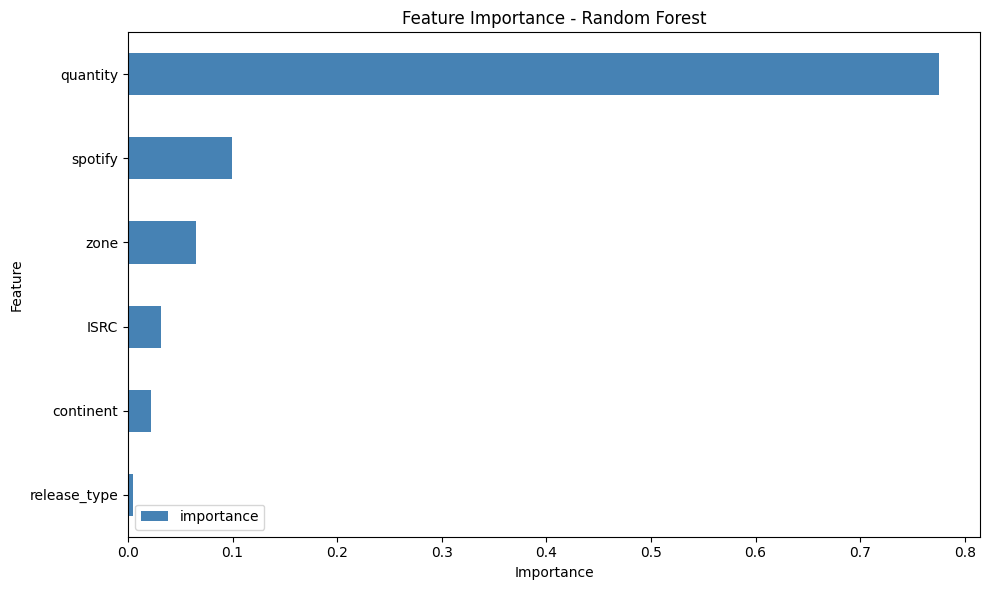

In [19]:
# Feature Importance from Random Forest
print("=" * 60)
print("FEATURE IMPORTANCE (Random Forest)")
print("=" * 60)
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))
print()

# Feature Importance visualization
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=ax, color='steelblue'
)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

SHAP ANALYSIS
Computing SHAP values (may take a moment)...


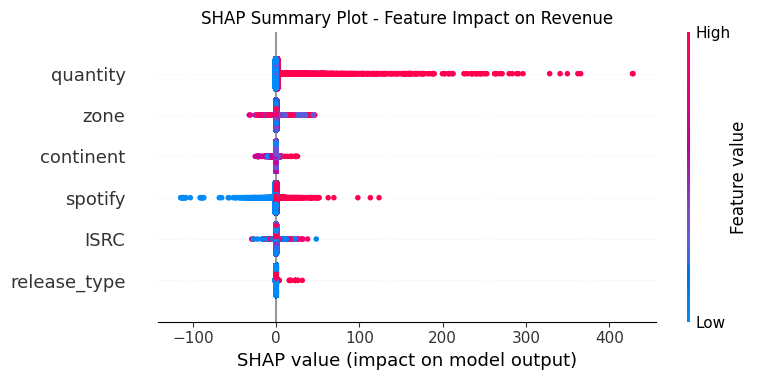

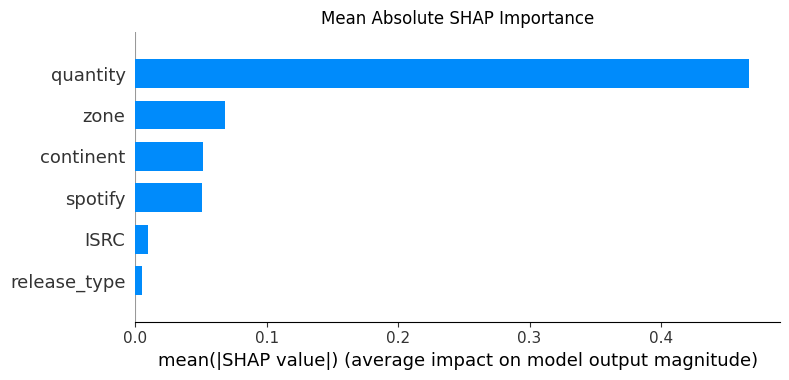


INTERPRETATION

DIFFERENCES BETWEEN FEATURE IMPORTANCE AND SHAP:

1. Feature Importance (RF):
   - Measures how much each variable improves the model globally
   - Based on impurity reduction (Gini/variance)
   - Can be biased towards variables with many categories

2. SHAP Values:
   - Shows the marginal impact of each variable
   - Considers interactions between variables
   - More robust and theoretically grounded
   - Allows seeing effect direction (positive/negative)

RECOMMENDATIONS:
- If quantity, unit_price and share_rate are most important:
  this makes sense because revenue = quantity × unit_price × share_rate
- If ISRC/zone are important: there may be specific patterns 
  per song or region that affect revenue
- SHAP is especially useful here to understand how each specific
  value of the variables affects individual revenue


EXAMPLE: SHAP EXPLANATION FOR ONE PREDICTION
Actual revenue: 2.10e-02
Predicted revenue: 1.22e-01

Contribution of each variable (SHAP values):
  ISR

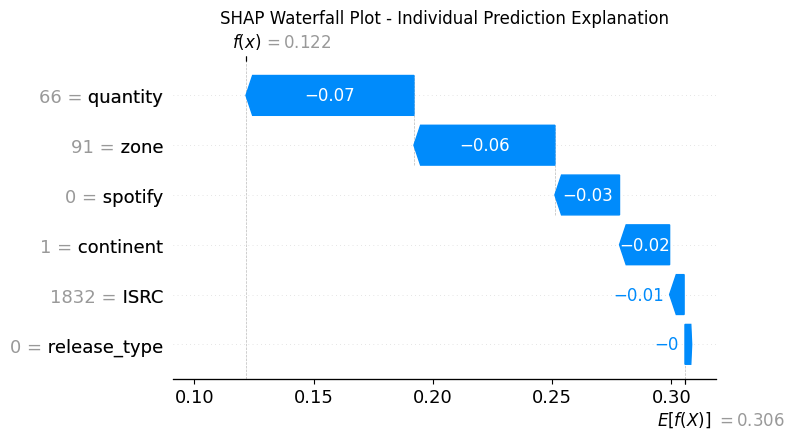

In [20]:
# SHAP Analysis
print("=" * 60)
print("SHAP ANALYSIS")
print("=" * 60)
print("Computing SHAP values (may take a moment)...")

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X_encoded.columns, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Revenue')
plt.tight_layout()
plt.show()

# Bar plot with mean absolute SHAP importance
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X_encoded.columns, 
                  plot_type="bar", show=False)
plt.title('Mean Absolute SHAP Importance')
plt.tight_layout()
plt.show()

print()
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("""
DIFFERENCES BETWEEN FEATURE IMPORTANCE AND SHAP:

1. Feature Importance (RF):
   - Measures how much each variable improves the model globally
   - Based on impurity reduction (Gini/variance)
   - Can be biased towards variables with many categories
   
2. SHAP Values:
   - Shows the marginal impact of each variable
   - Considers interactions between variables
   - More robust and theoretically grounded
   - Allows seeing effect direction (positive/negative)

RECOMMENDATIONS:
- If quantity, unit_price and share_rate are most important:
  this makes sense because revenue = quantity × unit_price × share_rate
- If ISRC/zone are important: there may be specific patterns 
  per song or region that affect revenue
- SHAP is especially useful here to understand how each specific
  value of the variables affects individual revenue
""")

# Example of individual prediction with SHAP
if len(X_test) > 0:
    print("\n" + "=" * 60)
    print("EXAMPLE: SHAP EXPLANATION FOR ONE PREDICTION")
    print("=" * 60)
    
    sample_idx = 0
    sample = X_test.iloc[sample_idx:sample_idx+1]
    
    shap_values_sample = explainer.shap_values(sample)
    
    print(f"Actual revenue: {y_test.iloc[sample_idx]:.2e}")
    print(f"Predicted revenue: {rf_model.predict(sample)[0]:.2e}")
    print("\nContribution of each variable (SHAP values):")
    
    for feat, shap_val in zip(X_encoded.columns, shap_values_sample[0]):
        print(f"  {feat}: {shap_val:.2e}")
    
    # Waterfall plot for individual prediction
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_sample[0],
            base_values=explainer.expected_value,
            data=sample.values[0],
            feature_names=X_encoded.columns.tolist()
        ),
        show=False
    )
    plt.title('SHAP Waterfall Plot - Individual Prediction Explanation')
    plt.tight_layout()
    plt.show()

In [22]:
2.10e-02

0.021

In [21]:
1.22e-01

0.122